<a href="https://colab.research.google.com/github/aakhterov/ML_algorithms_from_scratch/blob/master/A_B_testing_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0 - Getting Started

"Graffit" is a mobile app for listening to and watching various audio and video sources, making bookmarks, and transcribing audio fragments into text.

A graffit's team uses social media advertising to attract potential customers to their site. A product manager thinks the current ad banner can be improved and increase CTR. A new banner is ready but the product manager wants to conduct an A/B test before launch.

**Note**: The notebook based on the AB Testing Course on https://www.datainterview.com

In [20]:
from datetime import datetime
import math
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power, zt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep
from scipy.stats import norm

from google.colab import drive
drive.mount('/content/drive/')

# Disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

SEED = 123
np.random.seed(SEED)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/a_b_test_ctr.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%y')
df.head()

,Date,Impressions,Clicks,is_new_banner
0,2023-09-01,15159,193,0
1,2023-09-02,15014,90,0
2,2023-09-03,15219,148,0
3,2023-09-04,14970,146,0
4,2023-09-05,15016,125,0


In [3]:
df['CTR'] = df['Clicks']*100/df['Impressions'] # calculate CTR
current_ctr_mean = df['CTR'].mean().round(2)
print(f"The current average CTR is {current_ctr_mean}%")

The current average CTR is 0.84%


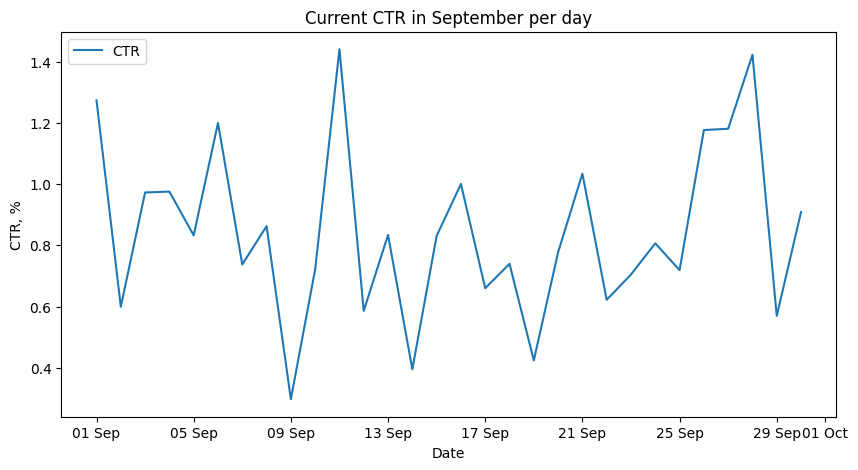

In [4]:
# Let's plot the CTR
_, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=df['Date'], y=df['CTR'])
plt.legend(labels=["CTR"])
plt.ylabel('CTR, %')
ax.xaxis.set_major_formatter(DateFormatter("%d %b"))
plt.title('Current CTR in September per day')
plt.show()

# Step 2 - State the Hypothesis

The second step of the experiment is to state the hypothesis. This is followed by setting parameter values such as the significance level (alpha), statistical power and minimum detctable effect (MDE).

$ H_0 $: The CTRs for the new banner and for the old one are the same.

$ H_a $ : The CTRs for the new banner and for the old one are different.

In [5]:
alpha = 0.05 # the segnificane level
power = 0.80 # the statistical power
mde = 0.20 # the minimum detectable effect (MDE)

p1 = current_ctr_mean # the current value of the CTR average
p2 = current_ctr_mean * (1 + mde) # the desired value of the CTR average

print(f"The current value of the CTR average: {p1}%\nThe desired value of the CTR average: {p2}%")

The current value of the CTR average: 0.84%
The desired value of the CTR average: 1.008%


# Step 3 - Design the Experiment

The third step of the experiment is the design the experiment which involves determining the randomization unit, calculating the sample size and determining the experiment duration. We will explore how to calculate the sample size and experiment duration in this section.

## Calculate Sample Size

In [6]:
effect_size = sm.stats.proportion_effectsize(p2/100, p1/100)
# Here use the folloeing eq: 2 * (np.arcsin(np.sqrt(p2/100)) - np.arcsin(np.sqrt(p1/100)))
print(f"Effect size of the two (current CTR and desired CTR) samples: {effect_size}")

Effect size of the two (current CTR and desired CTR) samples: 0.017576660160779328


In [7]:
# Calculate the sample size
nobs1 = zt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power)
n = math.ceil(nobs1) # the number of observations in the 1th sample
N = 2*n # the total number of observations
print(f"Number of observations in the 1th sample: {n}\nTotal number of observations: {N}")

Number of observations in the 1th sample: 50812
Total number of observations: 101624


## Experiment Duration

In [8]:
impessions_mean = df['Impressions'].mean()
dur = math.ceil(N/impessions_mean)
print(f"The average impressions per day: {impessions_mean}")
print(f"To achieve the required sample size it's needed {dur} days")

The average impressions per day: 14997.033333333333
To achieve the required sample size it's needed 7 days


# Step 4 - Run the Experiment

We will take a look at the step that involves running an experiment. The code below a simplified version of how data is collected and analyzed in a large scale experiment platform.

In [64]:
# Load data that was obtained after 7-days test
df_after = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/a_b_after_test_ctr.csv")
df_after['Date'] = pd.to_datetime(df_after['Date'], format='%d.%m.%y')
df_after.head()

,Date,Impressions,Clicks,is_new_banner
0,2023-10-15,7209,54,0
1,2023-10-16,7456,84,0
2,2023-10-17,7468,36,0
3,2023-10-18,7586,46,0
4,2023-10-19,7623,54,0


In [65]:
control_df = df_after[df_after['is_new_banner']==0]
treatment_df = df_after[df_after['is_new_banner']==1]

In [66]:
control_df['CTR'] = control_df['Clicks']*100/control_df['Impressions'] # calculate CTR of the control group
treatment_df['CTR'] = treatment_df['Clicks']*100/treatment_df['Impressions'] # calculate CTR of the treatment group
control_size = control_df['Impressions'].sum()
control_ctr_mean = control_df['CTR'].mean().round(2)
treatment_size = treatment_df['Impressions'].sum()
treatment_ctr_mean = treatment_df['CTR'].mean().round(2)
print(f"The control group average CTR is {control_ctr_mean}%. The control size is {control_size}.")
print(f"The treatment group average CTR is {treatment_ctr_mean}%. The treatment size is {treatment_size}.")

The control group average CTR is 0.79%. The control size is 52450.
The treatment group average CTR is 1.32%. The treatment size is 52790.


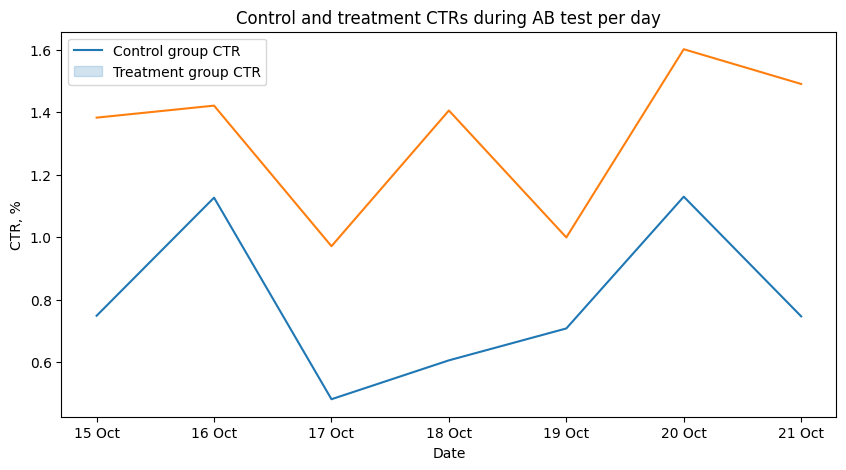

In [67]:
# Let's plot the CTR
_, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=control_df['Date'], y=control_df['CTR'])
sns.lineplot(x=treatment_df['Date'], y=treatment_df['CTR'])
plt.legend(labels=["Control group CTR", "Treatment group CTR"])
plt.ylabel('CTR, %')
ax.xaxis.set_major_formatter(DateFormatter("%d %b"))
plt.title('Control and treatment CTRs during AB test per day')
plt.show()

# Step 5 - Assess Validity Threats

In this step we will check for two of the checks for validity threats, which involve the AA test and the chi-square test for sample ratio mismatch (SRM).

Conducting checks for the experiment ensures that the AB test result is trustworthy and reduces risk of committing type 1 or 2 errors.

We run an AA test to ensure that there is no underlying difference between
the control and treatment to begin with. Note that in an actual experiment,
AA test would be conducted prior to the AB test.

We run a chi-square test on group sizes to check for sample-ratio mismatch (SRM). This test ensures that the randomization algorithm worked

There are other potential checks that could be performed including segmentation analysis to perform novelty checks and such.

But, for this exercise, we will keep it simple to just two checks.